

# Stock Market Prediction using LSTM, GRU and Hybrid

This notebook performs stock market prediction using a **Gated Recurrent Unit (GRU)** model and **Long Short Term Memory (LSTM)** and **Hybrid Model**.

It includes the following steps:
- Data Collection (Using `yfinance`)
- Data Preprocessing
- Exploratory Data Analysis (EDA)
- Feature Engineering
- Training a GRU and LSTM Model
- Predicting Stock Prices for the Next 10 Days
- Model Evaluation

**Dataset:** Latest stock data, starting from 10 days before today.


In [ ]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Set plot style
# plt.style.use("seaborn-darkgrid")


In [ ]:
def get_stock_data(stock_symbol, period, interval):
  """
  Fetches stock data from Yahoo Finance.
  Parameters:
    stock_symbol (str): The stock symbol (e.g., "AAPL" for Apple).
    period (str): The time period for which data is requested (e.g., "1mo",     "3mo", "6mo", "1y", "2y")
    interval (str): The interval between data points (e.g., "1d", "1wk", "1mo").
  Returns:
    pandas.DataFrame: A DataFrame containing the fetched stock data.
  """
  data = yf.download(stock_symbol, period=period, interval=interval)
  return data


Download 5 years worth of data from yfinance library.

In [ ]:
# Fetch stock data (10 days before today)
stock_symbol = "AAPL"  # Change to any stock ticker
period = "10y"
interval = "1d"

# Fetch data from Yahoo Finance
data = get_stock_data(stock_symbol, period, interval)

# Display first few rows
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-03-02,28.829367,29.095127,28.652939,28.865100,192386800
2015-03-03,28.889668,28.925401,28.606040,28.800338,151265200
2015-03-04,28.706533,28.934329,28.657404,28.831600,126665200
2015-03-05,28.230850,28.753436,28.085687,28.715471,226068400
2015-03-06,28.273275,28.891892,28.197345,28.675264,291368400


In [ ]:
# Extract only the closing prices
closing_prices = data[['Close']]

# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices)

# Add Moving Averages (Feature Engineering)
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()

# Drop NA values
data.dropna(inplace=True)

# Display data with new features
data.head()


Price,Close,High,Low,Open,Volume,SMA_50,SMA_200
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,
2015-12-11,25.605835,26.105825,25.531175,26.060578,187544800,26.176858,27.225652
2015-12-14,25.447466,25.492713,24.838880,25.379593,257274800,26.188489,27.208742
2015-12-15,24.997252,25.519867,24.965578,25.325300,213292400,26.189313,27.189280
2015-12-16,25.189552,25.336609,24.614904,25.128468,224954000,26.191596,27.171695
2015-12-17,24.655630,25.395434,24.655630,25.343398,179091200,26.185587,27.153819


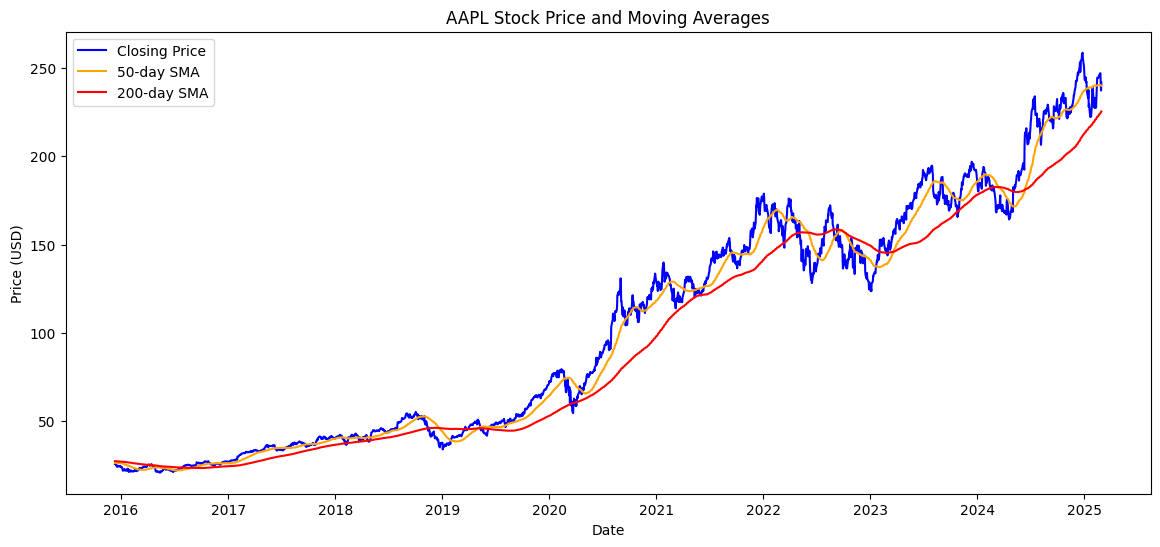

In [ ]:
# Visualizing Stock Price and Moving Averages
plt.figure(figsize=(14,6))
plt.plot(data['Close'], label="Closing Price", color='blue')
plt.plot(data['SMA_50'], label="50-day SMA", color='orange')
plt.plot(data['SMA_200'], label="200-day SMA", color='red')
plt.title(f"{stock_symbol} Stock Price and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [ ]:
# Function to create sequences for training
def create_sequences(data, time_steps=100):
    """
    Creates input-output sequences for time series forecasting.

    Parameters:
        data (np.ndarray): The input time series data.
        time_steps (int, optional): The number of time steps in each input sequence. Defaults to 100.

    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple containing:
            - X (np.ndarray): The input sequences.
            - y (np.ndarray): The corresponding target values.
    """
    X, y = [], []
    for i in range(len(data) - time_steps - 10):  # Reserve last 10 days for future prediction
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])  # Next day as target
    return np.array(X), np.array(y)

# Create sequences
time_steps = 100
X, y = create_sequences(scaled_data, time_steps)

# Reshape data for GRU model
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and test sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout

def create_lstm_model(input_shape, dropout_rate):
    """
    Creates and compiles an LSTM-based neural network model for time series forecasting.

    Parameters:
        input_shape (tuple[int, int]): The shape of the input data (time_steps, features).
        dropout_rate (float): The dropout rate to apply after LSTM layers.

    Returns:
        keras.Model: A compiled LSTM model with an Adam optimizer and mean squared error loss.
    """
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(50, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_gru_model(input_shape, dropout_rate):
    """
    Creates and compiles a GRU-based neural network model for time series forecasting.

    Parameters:
        input_shape (tuple[int, int]): The shape of the input data (time_steps, features).
        dropout_rate (float): The dropout rate to apply after GRU layers.

    Returns:
        keras.Model: A compiled GRU model with an Adam optimizer and mean squared error loss.
    """
    model = Sequential([
        GRU(50, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        GRU(50, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_hybrid_model(input_shape, dropout_rate):
    """
    Creates and compiles a hybrid model (LSTM + GRU) for time series forecasting.

    Parameters:
        input_shape (tuple[int, int]): The shape of the input data (time_steps, features).
        dropout_rate (float): The dropout rate to apply after hybrid layers.

    Returns:
        keras.Model: A compiled hybrid model with an Adam optimizer and mean squared error loss.
    """
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        GRU(50, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Get LSTM model and get summary of the model.
lstm_model = create_lstm_model(input_shape=(time_steps, 1), dropout_rate=0.2)
lstm_model.summary()
# Get GRU model and get summary of it.
gru_model = create_gru_model(input_shape=(time_steps, 1), dropout_rate=0.2)
gru_model.summary()
# Get Hybrid model and get summary of it.
hybrid_model = create_hybrid_model(input_shape=(time_steps, 1), dropout_rate=0.2)
hybrid_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                          │ (None, 100, 50)             │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,001 (105.47 KB)

 Trainable params: 27,001 (105.47 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train LSTM and GRU model one by one
# Separate it with big horizontal line

# Number of epochs is a hyperparameter so we can experiment with 25,50,75,100 epochs
def train_and_test_lstm(lstm_model, epochs, X_train, y_train, X_test, y_test):
  lstm_model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))
  lstm_predictions = lstm_model.predict(X_test)
  lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
  lstm_r2 = r2_score(y_test, lstm_predictions)
  print("LSTM Model:")
  print(f"Root Mean Squared Error: {lstm_rmse}")
  print(f"R² Score: {lstm_r2}")
  return lstm_predictions

def train_and_test_gru(gru_model, epochs, X_train, y_train, X_test, y_test):
  gru_model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))
  gru_predictions = gru_model.predict(X_test)
  gru_rmse = np.sqrt(mean_squared_error(y_test, gru_predictions))
  gru_r2 = r2_score(y_test, gru_predictions)
  print("GRU Model:")
  print(f"Root Mean Squared Error: {gru_rmse}")
  print(f"R² Score: {gru_r2}")
  return gru_predictions

def train_and_test_hybrid(hybrid_model, epochs, X_train, y_train, X_test, y_test):
  hybrid_model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))
  hybrid_predictions = hybrid_model.predict(X_test)
  hybrid_rmse = np.sqrt(mean_squared_error(y_test, hybrid_predictions))
  hybrid_r2 = r2_score(y_test, hybrid_predictions)
  print("Hybrid Model:")
  print(f"Root Mean Squared Error: {hybrid_rmse}")
  print(f"R² Score: {hybrid_r2}")
  return hybrid_predictions

In [ ]:
# After everytime the prediction happen we have to reinitialize the model, because if we do not do that then it will eventuly be better in every iteration and can go for overfitting in second experiment only.
print("=====================================================================")
print("Training LSTM model...")
lstm_model = create_lstm_model(input_shape=(time_steps, 1), dropout_rate=0.2)
lstm_predictions_25 = train_and_test_lstm(lstm_model, 25, X_train, y_train, X_test, y_test)
print("=====================================================================")
print("Training LSTM model with 50 epochs...")
lstm_model_50 = create_lstm_model(input_shape=(time_steps, 1), dropout_rate=0.2)
lstm_predictions_50 = train_and_test_lstm(lstm_model_50, 50, X_train, y_train, X_test, y_test)
print("=====================================================================")
print("Training LSTM model with 75 epochs...")
lstm_model_75 = create_lstm_model(input_shape=(time_steps, 1), dropout_rate=0.2)
lstm_predictions_75 = train_and_test_lstm(lstm_model_75, 75, X_train, y_train, X_test, y_test)
print("=====================================================================")
print("Training LSTM model with 100 epochs...")
lstm_model_100 = create_lstm_model(input_shape=(time_steps, 1), dropout_rate=0.2)
lstm_predictions_100 = train_and_test_lstm(lstm_model_100, 100, X_train, y_train, X_test, y_test)
print("=====================================================================")

Training LSTM model...
Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0185 - val_loss: 0.0013
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.4126e-04 - val_loss: 7.9838e-04
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.4901e-04 - val_loss: 0.0061
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.0270e-04 - val_loss: 0.0045
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.4737e-04 - val_loss: 0.0015
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.7399e-04 - val_loss: 0.0043
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.6989e-04 - val_loss: 0.0032
Epoch 9/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.7406e-04 - val_loss: 0.0016
Epoch 10/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.0438e-04 - val_loss: 6.3262e-04
Epoch 11/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.3904e-04 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0159 - val_loss: 0.0010
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.6844e-04 - val_loss: 0.0016
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.9743e-04 - val_loss: 6.5945e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.0839e-04 - val_loss: 0.0015
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.0141e-04 - val_loss: 0.0019
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.8652e-04 - val_loss: 6.2599e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.4915e-04 - val_loss: 7.4738e-04
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.5267e-04 - val_loss: 0.0014
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.3384e-04 - val_loss: 0.0027
Epoch 12/50
61/61 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0257 - val_loss: 0.0018
Epoch 2/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - val_loss: 8.6320e-04
Epoch 4/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.9259e-04 - val_loss: 0.0035
Epoch 5/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.7200e-04 - val_loss: 0.0033
Epoch 6/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.1052e-04 - val_loss: 0.0011
Epoch 7/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.9839e-04 - val_loss: 0.0020
Epoch 8/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.4641e-04 - val_loss: 0.0042
Epoch 9/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.8874e-04 - val_loss: 6.8136e-04
Epoch 10/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.0097e-04 - val_loss: 0.0022
Epoch 11/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.9404e-04 - val_loss: 6.7791e-04
Epoch 12/75
61/61 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0178 - val_loss: 0.0017
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.5552e-04 - val_loss: 0.0019
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.8396e-04 - val_loss: 6.8147e-04
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.6208e-04 - val_loss: 0.0036
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.9359e-04 - val_loss: 0.0019
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.1854e-04 - val_loss: 9.8034e-04
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.3226e-04 - val_loss: 0.0031
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.0949e-04 - val_loss: 5.6809e-04
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.0758e-04 - val_loss: 7.6279e-04
Epoch 12/100
61/

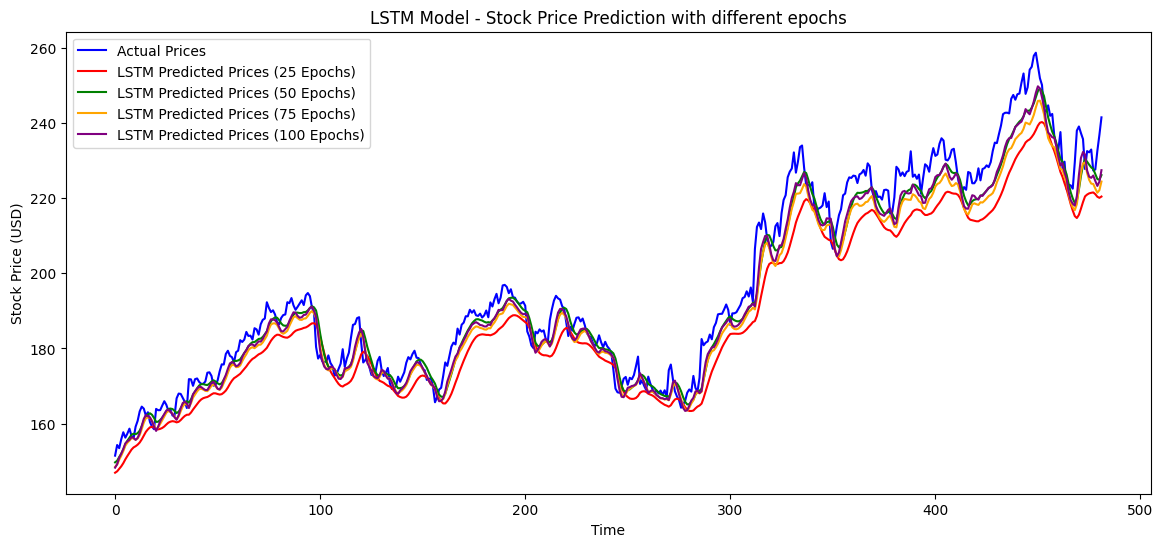

In [ ]:
# Convert all the predictions using interse transform and put the into single graph that so that the difference between the prediction can be easy to understand.
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
lstm_predicted_prices_25 = scaler.inverse_transform(lstm_predictions_25.reshape(-1, 1))
lstm_predicted_prices_50 = scaler.inverse_transform(lstm_predictions_50.reshape(-1, 1))
lstm_predicted_prices_75 = scaler.inverse_transform(lstm_predictions_75.reshape(-1, 1))
lstm_predicted_prices_100 = scaler.inverse_transform(lstm_predictions_100.reshape(-1, 1))

plt.figure(figsize=(14,6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(lstm_predicted_prices_25, label="LSTM Predicted Prices (25 Epochs)", color='red')
plt.plot(lstm_predicted_prices_50, label="LSTM Predicted Prices (50 Epochs)", color='green')
plt.plot(lstm_predicted_prices_75, label="LSTM Predicted Prices (75 Epochs)", color='orange')
plt.plot(lstm_predicted_prices_100, label="LSTM Predicted Prices (100 Epochs)", color='purple')
plt.title("LSTM Model - Stock Price Prediction with different epochs")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()



In [ ]:
# From the predictions 100 epochs is good initialization to tune the model.
# Next we can adjust the drouout rate 0.25, 0.5, 0.75
print("=====================================================================")
print("Training LSTM model with 0.25 dropout rate...")
lstm_model_dr_25 = create_lstm_model(input_shape=(time_steps, 1), dropout_rate=0.25)
lstm_predictions_dr_25 = train_and_test_lstm(lstm_model_dr_25, 100, X_train, y_train, X_test, y_test)
print("=====================================================================")
print("Training LSTM model with 0.5 dropout rate...")
lstm_model_dr_50 = create_lstm_model(input_shape=(time_steps, 1), dropout_rate=0.5)
lstm_predictions_dr_50 = train_and_test_lstm(lstm_model_dr_50, 100, X_train, y_train, X_test, y_test)
print("=====================================================================")
print("Training LSTM model with 0.75 dropout rate...")
lstm_model_dr_75 = create_lstm_model(input_shape=(time_steps, 1), dropout_rate=0.75)
lstm_predictions_dr_75 = train_and_test_lstm(lstm_model_dr_75, 100, X_train, y_train, X_test, y_test)
print("=====================================================================")

Training LSTM model with 0.25 dropout rate...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0244 - val_loss: 0.0014
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 0.0088
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.1574e-04 - val_loss: 0.0015
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.0082e-04 - val_loss: 0.0023
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.6995e-04 - val_loss: 0.0050
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.0726e-04 - val_loss: 0.0018
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.8384e-04 - val_loss: 6.9632e-04
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0331 - val_loss: 6.8782e-04
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016 - val_loss: 8.8926e-04
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0246 - val_loss: 0.0028
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0040 - val_loss: 0.0064
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0043 - val_loss: 0.0066
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0034 - val_loss: 0.0051
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0035 - val_loss: 0.0053
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

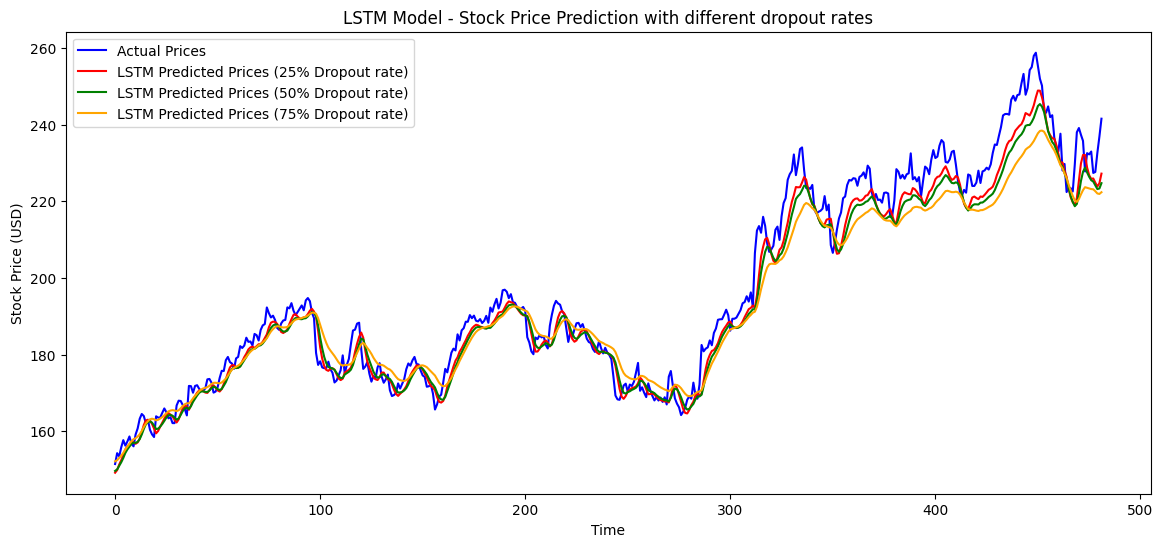

In [ ]:
# Summarize everything into one graph
# Before that need to do inverse transformation of predictions
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
lstm_predicted_prices_dr_25 = scaler.inverse_transform(lstm_predictions_dr_25.reshape(-1, 1))
lstm_predicted_prices_dr_50 = scaler.inverse_transform(lstm_predictions_dr_50.reshape(-1, 1))
lstm_predicted_prices_dr_75 = scaler.inverse_transform(lstm_predictions_dr_75.reshape(-1, 1))

plt.figure(figsize=(14,6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(lstm_predicted_prices_dr_25, label="LSTM Predicted Prices (25% Dropout rate)", color='red')
plt.plot(lstm_predicted_prices_dr_50, label="LSTM Predicted Prices (50% Dropout rate)", color='green')
plt.plot(lstm_predicted_prices_dr_75, label="LSTM Predicted Prices (75% Dropout rate)", color='orange')
plt.title("LSTM Model - Stock Price Prediction with different dropout rates")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

In [ ]:
# Can implement the same analysis for GRU for number of epochs and dropout rate and for that the function gru_train_test can be used
print("=====================================================================")
print("Training GRU model...")
gru_model = create_gru_model(input_shape=(time_steps, 1), dropout_rate=0.2)
gru_predictions_25 = train_and_test_gru(gru_model, 25, X_train, y_train, X_test, y_test)
print("=====================================================================")
print("Training GRU model with 50 epochs...")
gru_model_50 = create_gru_model(input_shape=(time_steps, 1), dropout_rate=0.2)
gru_predictions_50 = train_and_test_gru(gru_model_50, 50, X_train, y_train, X_test, y_test)
print("=====================================================================")
print("Training GRU model with 75 epochs...")
gru_model_75 = create_gru_model(input_shape=(time_steps, 1), dropout_rate=0.2)
gru_predictions_75 = train_and_test_gru(gru_model_75, 75, X_train, y_train, X_test, y_test)
print("=====================================================================")
print("Training GRU model with 100 epochs...")
gru_model_100 = create_gru_model(input_shape=(time_steps, 1), dropout_rate=0.2)
gru_predictions_100 = train_and_test_gru(gru_model_100, 100, X_train, y_train, X_test, y_test)
print("=====================================================================")

Training GRU model...
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0151 - val_loss: 4.2745e-04
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 3.7336e-04
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - val_loss: 7.5091e-04
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.9593e-04 - val_loss: 3.1101e-04
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.7229e-04 - val_loss: 3.9382e-04
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.2275e-04 - val_loss: 3.8016e-04
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.7137e-04 - val_loss: 3.6628e-04
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.4376e-04 - val_loss: 4.9792e-04
Epoch 9/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.7291e-04 - val_loss: 0.0014
Epoch 10/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.3321e-04 - val_loss: 2.8305e-04
Epoch 11/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.4251e-04 - val_loss: 3.6814e-04
Ep

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0135 - val_loss: 0.0020
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017 - val_loss: 3.5550e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0013 - val_loss: 2.9982e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.6502e-04 - val_loss: 3.6320e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.5649e-04 - val_loss: 6.7707e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.9970e-04 - val_loss: 4.2111e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.4563e-04 - val_loss: 0.0014
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.9068e-04 - val_loss: 3.1108e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.6621e-04 - val_loss: 9.1938e-04
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8072e-04 - val_loss: 5.6852e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7257e-04 - val_loss: 3.3987e-04
Epoch 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0121 - val_loss: 8.9068e-04
Epoch 2/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - val_loss: 4.3559e-04
Epoch 3/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - val_loss: 6.6152e-04
Epoch 4/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.7902e-04 - val_loss: 6.7064e-04
Epoch 5/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.3985e-04 - val_loss: 4.5236e-04
Epoch 6/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.0351e-04 - val_loss: 4.9471e-04
Epoch 7/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.9580e-04 - val_loss: 0.0020
Epoch 8/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.6714e-04 - val_loss: 4.4014e-04
Epoch 9/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.1981e-04 - val_loss: 0.0010
Epoch 10/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5558e-04 - val_loss: 2.7265e-04
Epoch 11/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.2703e-04 - val_loss: 2.9304e-04
Epoch 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0183 - val_loss: 0.0020
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 9.0690e-04
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.6001e-04 - val_loss: 3.0881e-04
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.5738e-04 - val_loss: 3.1046e-04
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.2249e-04 - val_loss: 9.8276e-04
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.3983e-04 - val_loss: 3.5032e-04
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.1006e-04 - val_loss: 5.4096e-04
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8767e-04 - val_loss: 9.7644e-04
Epoch 12/100

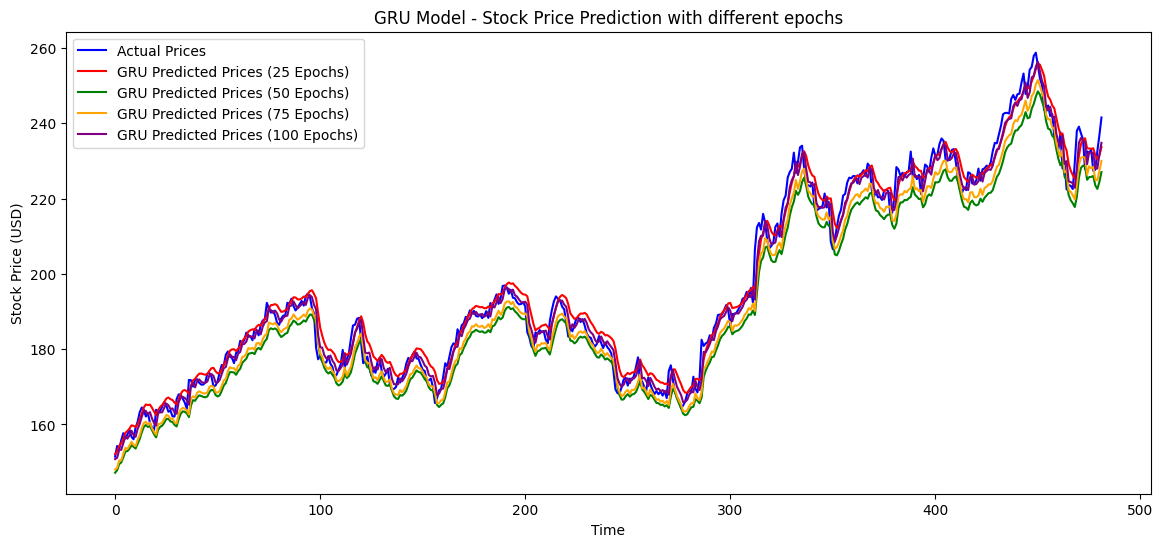

In [ ]:
# Summarize everything into one graph
# Before that need to do inverse transformation of predictions
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
gru_predicted_prices_25 = scaler.inverse_transform(gru_predictions_25.reshape(-1,1))
gru_predicted_prices_50 = scaler.inverse_transform(gru_predictions_50.reshape(-1,1))
gru_predicted_prices_75 = scaler.inverse_transform(gru_predictions_75.reshape(-1,1))
gru_predicted_prices_100 = scaler.inverse_transform(gru_predictions_100.reshape(-1,1))

plt.figure(figsize=(14,6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(gru_predicted_prices_25, label="GRU Predicted Prices (25 Epochs)", color='red')
plt.plot(gru_predicted_prices_50, label="GRU Predicted Prices (50 Epochs)", color='green')
plt.plot(gru_predicted_prices_75, label="GRU Predicted Prices (75 Epochs)", color='orange')
plt.plot(gru_predicted_prices_100, label="GRU Predicted Prices (100 Epochs)", color='purple')
plt.title("GRU Model - Stock Price Prediction with different epochs")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

In [ ]:
# Train and Test Hybrid model
print("=====================================================================")
print("Training Hybrid model...")
hybrid_model = create_hybrid_model(input_shape=(time_steps, 1), dropout_rate=0.2)
hybrid_predictions_25 = train_and_test_hybrid(hybrid_model, 25, X_train, y_train, X_test, y_test)
print("=====================================================================")
print("Training Hybrid model with 50 epochs...")
hybrid_model_50 = create_hybrid_model(input_shape=(time_steps, 1), dropout_rate=0.2)
hybrid_predictions_50 = train_and_test_hybrid(hybrid_model_50, 50, X_train, y_train, X_test, y_test)
print("=====================================================================")
print("Training Hybrid model with 75 epochs...")
hybrid_model_75 = create_hybrid_model(input_shape=(time_steps, 1), dropout_rate=0.2)
hybrid_predictions_75 = train_and_test_hybrid(hybrid_model_75, 75, X_train, y_train, X_test, y_test)
print("=====================================================================")
print("Training Hybrid model with 100 epochs...")
hybrid_model_100 = create_hybrid_model(input_shape=(time_steps, 1), dropout_rate=0.2)
hybrid_predictions_100 = train_and_test_hybrid(hybrid_model_100, 100, X_train, y_train, X_test, y_test)
print("=====================================================================")

Training Hybrid model...
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0242 - val_loss: 0.0013
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0010 - val_loss: 5.5832e-04
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.2398e-04 - val_loss: 8.0197e-04
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.0053e-04 - val_loss: 0.0016
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.8123e-04 - val_loss: 0.0036
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.1523e-04 - val_loss: 5.4992e-04
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.6163e-04 - val_loss: 6.5383e-04
Epoch 9/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.3357e-04 - val_loss: 0.0015
Epoch 10/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.7010e-04 - val_loss: 5.1441e-04
Epoch 11/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.8476e-04 - val_loss: 0.0044
Epoch 12/25
61/61 ━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0168 - val_loss: 9.2042e-04
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011 - val_loss: 5.6314e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.4793e-04 - val_loss: 0.0021
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.6084e-04 - val_loss: 0.0010
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.7486e-04 - val_loss: 0.0023
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.6208e-04 - val_loss: 0.0016
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.2792e-04 - val_loss: 5.3536e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.3530e-04 - val_loss: 5.8378e-04
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.9302e-04 - val_loss: 9.3232e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.3732e-04 - val_loss: 0.0012
Epoch 12/50
61/61 ━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0292 - val_loss: 0.0019
Epoch 2/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - val_loss: 5.8377e-04
Epoch 3/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 8.4268e-04
Epoch 4/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 6/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.9670e-04 - val_loss: 0.0013
Epoch 7/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.6821e-04 - val_loss: 5.1223e-04
Epoch 8/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.9512e-04 - val_loss: 6.9074e-04
Epoch 9/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.3806e-04 - val_loss: 6.1751e-04
Epoch 10/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.6298e-04 - val_loss: 0.0019
Epoch 11/75
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.6966e-04 - val_loss: 0.0010
Epoch 12/75
61/61 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0213 - val_loss: 5.9662e-04
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - val_loss: 6.2879e-04
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - val_loss: 7.1374e-04
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.2747e-04 - val_loss: 5.4092e-04
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.7865e-04 - val_loss: 8.0288e-04
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.4098e-04 - val_loss: 7.4133e-04
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.5000e-04 - val_loss: 8.5502e-04
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7.2454e-04 - val_loss: 5.3943e-04
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.8319e-04 - val_loss: 0.0014
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.5323e-04 - val_loss: 0.0013
Epoc

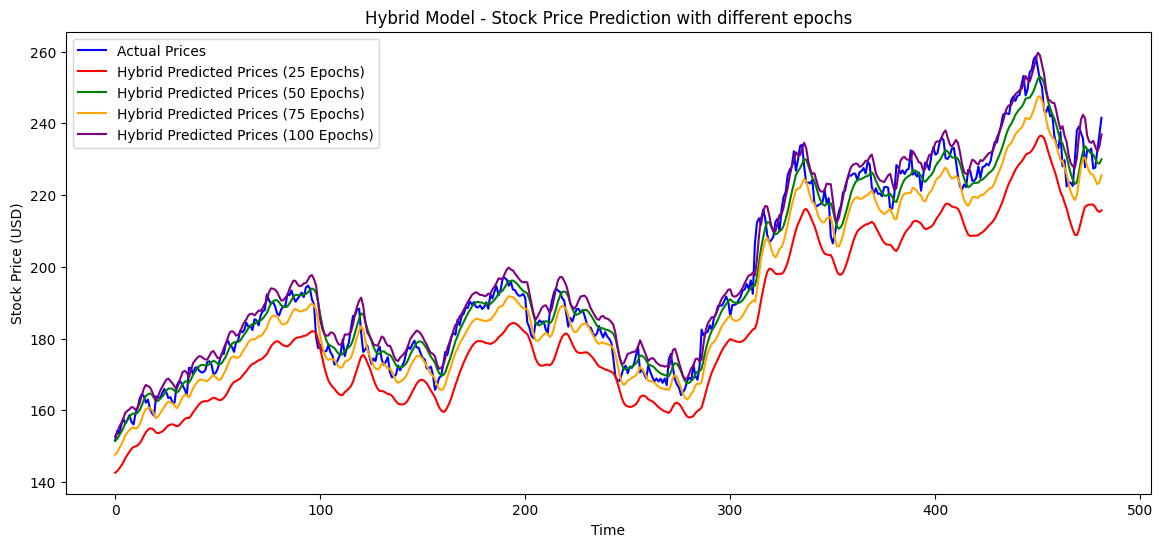

In [ ]:
# Summarize everything into one graph
# Before that need to do inverse transformation of predictions
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
hybrid_predicted_prices_25 = scaler.inverse_transform(hybrid_predictions_25.reshape(-1,1))
hybrid_predicted_prices_50 = scaler.inverse_transform(hybrid_predictions_50.reshape(-1,1))
hybrid_predicted_prices_75 = scaler.inverse_transform(hybrid_predictions_75.reshape(-1,1))
hybrid_predicted_prices_100 = scaler.inverse_transform(hybrid_predictions_100.reshape(-1,1))

plt.figure(figsize=(14,6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(hybrid_predicted_prices_25, label="Hybrid Predicted Prices (25 Epochs)", color='red')
plt.plot(hybrid_predicted_prices_50, label="Hybrid Predicted Prices (50 Epochs)", color='green')
plt.plot(hybrid_predicted_prices_75, label="Hybrid Predicted Prices (75 Epochs)", color='orange')
plt.plot(hybrid_predicted_prices_100, label="Hybrid Predicted Prices (100 Epochs)", color='purple')
plt.title("Hybrid Model - Stock Price Prediction with different epochs")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━

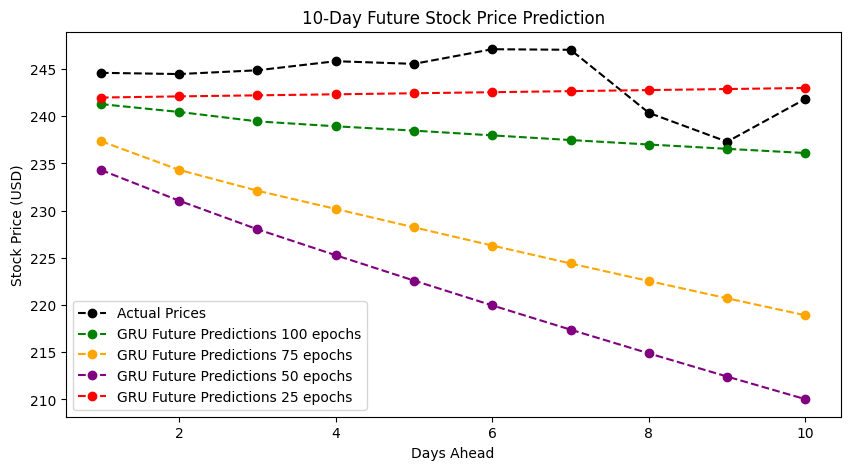

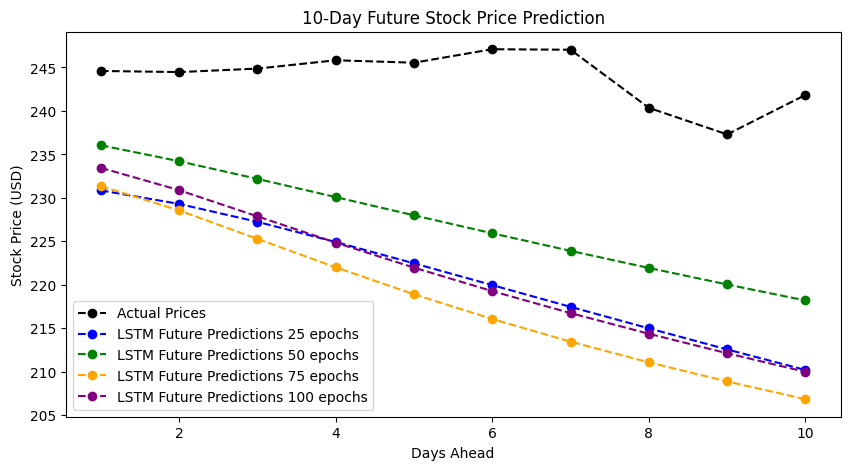

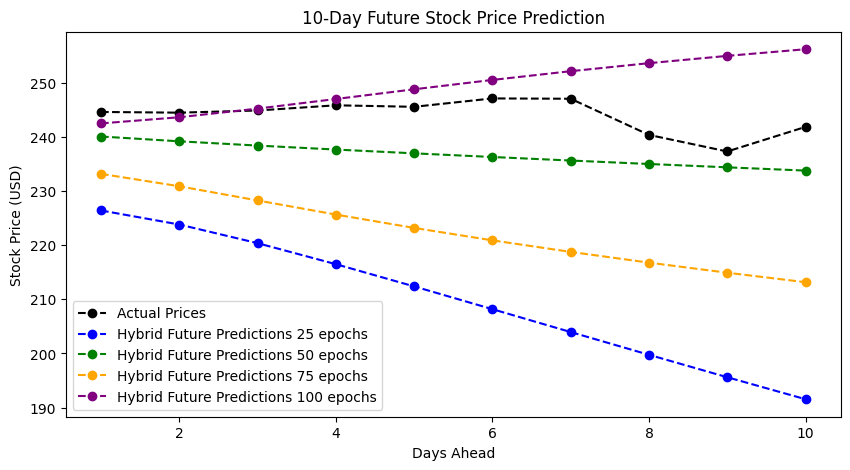

In [ ]:
# =============Future Stock Price Prediction ==================== #

# Step 1: Prepare the last 100 days of data for making future predictions.
# The last 100 time steps from the scaled dataset are reshaped to match the input format
# expected by the LSTM and GRU models (batch_size=1, time_steps=100, features=1).
# last_100_days_lstm = scaled_data[-100:].reshape(1, 100, 1)
last_100_days_gru_100 = scaled_data[-100:].reshape(1, 100, 1)
last_100_days_gru_75 = scaled_data[-100:].reshape(1, 100, 1)
last_100_days_gru_50 = scaled_data[-100:].reshape(1, 100, 1)
last_100_days_gru_25 = scaled_data[-100:].reshape(1, 100, 1)
last_100_days_lstm_25 = scaled_data[-100:].reshape(1, 100, 1)
last_100_days_lstm_50 = scaled_data[-100:].reshape(1, 100, 1)
last_100_days_lstm_75 = scaled_data[-100:].reshape(1, 100, 1)
last_100_days_lstm_100 = scaled_data[-100:].reshape(1, 100, 1)
last_100_days_hybrid_25 = scaled_data[-100:].reshape(1, 100, 1)
last_100_days_hybrid_50 = scaled_data[-100:].reshape(1, 100, 1)
last_100_days_hybrid_75 = scaled_data[-100:].reshape(1, 100, 1)
last_100_days_hybrid_100 = scaled_data[-100:].reshape(1, 100, 1)

# Step 2: Predict stock prices for the next 10 days using the trained LSTM and GRU models.
# We perform iterative forecasting where each predicted value is fed back into the model
# as input for the next time step.
# future_prediction_lstm = []
future_prediction_gru_100 = []
future_prediction_gru_75 = []
future_prediction_gru_50 = []
future_prediction_gru_25 = []
future_prediction_lstm_25 = []
future_prediction_lstm_50 = []
future_prediction_lstm_75 = []
future_prediction_lstm_100 = []
future_prediction_hybrid_25 = []
future_prediction_hybrid_50 = []
future_prediction_hybrid_75 = []
future_prediction_hybrid_100 = []

for _ in range(10):
  # Generate the next day's stock price prediction
    # lstm_predicted = lstm_model.predict(last_100_days_lstm)[0][0]
    gru_predicted_100 = gru_model_100.predict(last_100_days_gru_100)[0][0]
    gru_predicted_75 = gru_model_75.predict(last_100_days_gru_75)[0][0]
    gru_predicted_50 = gru_model_50.predict(last_100_days_gru_50)[0][0]
    gru_predicted_25 = gru_model.predict(last_100_days_gru_25)[0][0]
    lstm_predicted_prices_25 = lstm_model.predict(last_100_days_lstm_25)[0][0]
    lstm_predicted_prices_50 = lstm_model_50.predict(last_100_days_lstm_50)[0][0]
    lstm_predicted_prices_75 = lstm_model_75.predict(last_100_days_lstm_75)[0][0]
    lstm_predicted_prices_100 = lstm_model_100.predict(last_100_days_lstm_100)[0][0]
    hybrid_predicted_25 = hybrid_model.predict(last_100_days_hybrid_25)[0][0]
    hybrid_predicted_50 = hybrid_model_50.predict(last_100_days_hybrid_50)[0][0]
    hybrid_predicted_75 = hybrid_model_75.predict(last_100_days_hybrid_75)[0][0]
    hybrid_predicted_100 = hybrid_model_100.predict(last_100_days_hybrid_100)[0][0]

    # Store the predictions
    # future_prediction_lstm.append(lstm_predicted)
    future_prediction_gru_100.append(gru_predicted_100)
    future_prediction_gru_75.append(gru_predicted_75)
    future_prediction_gru_50.append(gru_predicted_50)
    future_prediction_gru_25.append(gru_predicted_25)
    future_prediction_lstm_25.append(lstm_predicted_prices_25)
    future_prediction_lstm_50.append(lstm_predicted_prices_50)
    future_prediction_lstm_75.append(lstm_predicted_prices_75)
    future_prediction_lstm_100.append(lstm_predicted_prices_100)
    future_prediction_hybrid_25.append(hybrid_predicted_25)
    future_prediction_hybrid_50.append(hybrid_predicted_50)
    future_prediction_hybrid_75.append(hybrid_predicted_75)
    future_prediction_hybrid_100.append(hybrid_predicted_100)
    # Update the last 100 days dataset by appending the new prediction and removing the oldest value
    # last_100_days_lstm = np.append(last_100_days_lstm[:,1:,:], [[[lstm_predicted]]], axis=1)
    last_100_days_gru_100 = np.append(last_100_days_gru_100[:,1:,:], [[[gru_predicted_100]]], axis=1)
    last_100_days_gru_75 = np.append(last_100_days_gru_75[:,1:,:], [[[gru_predicted_75]]], axis=1)
    last_100_days_gru_50 = np.append(last_100_days_gru_50[:,1:,:], [[[gru_predicted_50]]], axis=1)
    last_100_days_gru_25 = np.append(last_100_days_gru_25[:,1:,:], [[[gru_predicted_25]]], axis=1)
    last_100_days_lstm_25 = np.append(last_100_days_lstm_25[:,1:,:], [[[lstm_predicted_prices_25]]], axis=1)
    last_100_days_lstm_50 = np.append(last_100_days_lstm_50[:,1:,:], [[[lstm_predicted_prices_50]]], axis=1)
    last_100_days_lstm_75 = np.append(last_100_days_lstm_75[:,1:,:], [[[lstm_predicted_prices_75]]], axis=1)
    last_100_days_lstm_100 = np.append(last_100_days_lstm_100[:,1:,:], [[[lstm_predicted_prices_100]]], axis=1)
    last_100_days_hybrid_25 = np.append(last_100_days_hybrid_25[:,1:,:], [[[hybrid_predicted_25]]], axis=1)
    last_100_days_hybrid_50 = np.append(last_100_days_hybrid_50[:,1:,:], [[[hybrid_predicted_50]]], axis=1)
    last_100_days_hybrid_75 = np.append(last_100_days_hybrid_75[:,1:,:], [[[hybrid_predicted_75]]], axis=1)
    last_100_days_hybrid_100 = np.append(last_100_days_hybrid_100[:,1:,:], [[[hybrid_predicted_100]]], axis=1)


# Step 3: Convert the predicted values back to the original scale.
# Since the model was trained on normalized data, we use the scaler's inverse transform
# to get the actual predicted stock prices.
# future_prices_lstm = scaler.inverse_transform(np.array(future_prediction_lstm).reshape(-1,1))
future_prices_gru_100 = scaler.inverse_transform(np.array(future_prediction_gru_100).reshape(-1,1))
future_prices_gru_75 = scaler.inverse_transform(np.array(future_prediction_gru_75).reshape(-1,1))
future_prices_gru_50 = scaler.inverse_transform(np.array(future_prediction_gru_50).reshape(-1,1))
future_prices_gru_25 = scaler.inverse_transform(np.array(future_prediction_gru_25).reshape(-1,1))
future_prices_lstm_25 = scaler.inverse_transform(np.array(future_prediction_lstm_25).reshape(-1,1))
future_prices_lstm_50 = scaler.inverse_transform(np.array(future_prediction_lstm_50).reshape(-1,1))
future_prices_lstm_75 = scaler.inverse_transform(np.array(future_prediction_lstm_75).reshape(-1,1))
future_prices_lstm_100 = scaler.inverse_transform(np.array(future_prediction_lstm_100).reshape(-1,1))
future_prices_hybrid_25 = scaler.inverse_transform(np.array(future_prediction_hybrid_25).reshape(-1,1))
future_prices_hybrid_50 = scaler.inverse_transform(np.array(future_prediction_hybrid_50).reshape(-1,1))
future_prices_hybrid_75 = scaler.inverse_transform(np.array(future_prediction_hybrid_75).reshape(-1,1))
future_prices_hybrid_100 = scaler.inverse_transform(np.array(future_prediction_hybrid_100).reshape(-1,1))

# Also retrive original price for last 10 days from data
actual_prices = data['Close'].tail(10).values.reshape(-1,1)



# Step 4: Display the predicted stock prices for the next 10 days.
print("Predicted Stock Prices for the Next 10 Days:")
print("LSTM Model:")
# print(future_prices_lstm.flatten())
print("\nGRU Model:")
print(future_prices_gru_100.flatten())
print(future_prices_gru_75.flatten())
print(future_prices_gru_50.flatten())
print(future_prices_gru_25.flatten())

# Step 5: Visualize the future predictions using a line plot.
plt.figure(figsize=(10,5))
# plt.plot(range(1,11), future_prices_lstm, marker='o', linestyle='dashed', color='blue', label="LSTM Future Predictions")
plt.plot(range(1,11), actual_prices, marker='o', linestyle='dashed', color='black', label="Actual Prices")
plt.plot(range(1,11), future_prices_gru_100, marker='o', linestyle='dashed', color='green', label="GRU Future Predictions 100 epochs")
plt.plot(range(1,11), future_prices_gru_75, marker='o', linestyle='dashed', color='orange', label="GRU Future Predictions 75 epochs")
plt.plot(range(1,11), future_prices_gru_50, marker='o', linestyle='dashed', color='purple', label="GRU Future Predictions 50 epochs")
plt.plot(range(1,11), future_prices_gru_25, marker='o', linestyle='dashed', color='red', label="GRU Future Predictions 25 epochs")
plt.title("10-Day Future Stock Price Prediction")
plt.xlabel("Days Ahead")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

# step 6 visualize the future predictions using a line plot for LSTM predictions
plt.figure(figsize=(10,5))
plt.plot(range(1,11), actual_prices, marker='o', linestyle='dashed', color='black', label="Actual Prices")
plt.plot(range(1,11), future_prices_lstm_25, marker='o', linestyle='dashed', color='blue', label="LSTM Future Predictions 25 epochs")
plt.plot(range(1,11), future_prices_lstm_50, marker='o', linestyle='dashed', color='green', label="LSTM Future Predictions 50 epochs")
plt.plot(range(1,11), future_prices_lstm_75, marker='o', linestyle='dashed', color='orange', label="LSTM Future Predictions 75 epochs")
plt.plot(range(1,11), future_prices_lstm_100, marker='o', linestyle='dashed', color='purple', label="LSTM Future Predictions 100 epochs")
plt.title("10-Day Future Stock Price Prediction")
plt.xlabel("Days Ahead")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

# Visualize the future predictions using a line plot for Hybrid model predictions
plt.figure(figsize=(10,5))
plt.plot(range(1,11), actual_prices, marker='o', linestyle='dashed', color='black', label="Actual Prices")
plt.plot(range(1,11), future_prices_hybrid_25, marker='o', linestyle='dashed', color='blue', label="Hybrid Future Predictions 25 epochs")
plt.plot(range(1,11), future_prices_hybrid_50, marker='o', linestyle='dashed', color='green', label="Hybrid Future Predictions 50 epochs")
plt.plot(range(1,11), future_prices_hybrid_75, marker='o', linestyle='dashed', color='orange', label="Hybrid Future Predictions 75 epochs")
plt.plot(range(1,11), future_prices_hybrid_100, marker='o', linestyle='dashed', color='purple', label="Hybrid Future Predictions 100 epochs")
plt.title("10-Day Future Stock Price Prediction")
plt.xlabel("Days Ahead")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

In [ ]:
# Put the information of predicted LSTM prices and actual prices in table format
# with actual prices and predicted price along with difference
price_diff_gru_100 = []
price_diff_gru_75 = []
price_diff_gru_50 = []
price_diff_gru_25 = []
price_diff_lstm_25 = []
price_diff_lstm_50 = []
price_diff_lstm_75 = []
price_diff_lstm_100 = []
price_diff_hybrid_25 = []
price_diff_hybrid_50 = []
price_diff_hybrid_75 = []
price_diff_hybrid_100 = []
for i in range(len(actual_prices)):
  price_diff_gru_100.append(abs(future_prices_gru_100[i][0] - actual_prices[i][0]))
  price_diff_gru_75.append(abs(future_prices_gru_75[i][0] - actual_prices[i][0]))
  price_diff_gru_50.append(abs(future_prices_gru_50[i][0] - actual_prices[i][0]))
  price_diff_gru_25.append(abs(future_prices_gru_25[i][0] - actual_prices[i][0]))
  price_diff_lstm_25.append(abs(future_prices_lstm_25[i][0] - actual_prices[i][0]))
  price_diff_lstm_50.append(abs(future_prices_lstm_50[i][0] - actual_prices[i][0]))
  price_diff_lstm_75.append(abs(future_prices_lstm_75[i][0] - actual_prices[i][0]))
  price_diff_lstm_100.append(abs(future_prices_lstm_100[i][0] - actual_prices[i][0]))
  price_diff_hybrid_25.append(abs(future_prices_hybrid_25[i][0] - actual_prices[i][0]))
  price_diff_hybrid_50.append(abs(future_prices_hybrid_50[i][0] - actual_prices[i][0]))
  price_diff_hybrid_75.append(abs(future_prices_hybrid_75[i][0] - actual_prices[i][0]))
  price_diff_hybrid_100.append(abs(future_prices_hybrid_100[i][0] - actual_prices[i][0]))

print("===============================================================")
print("Display Avereage price difference for GRU")
print("For 100 epochs: ", np.mean(price_diff_gru_100))
print("For 75 epochs: ", np.mean(price_diff_gru_75))
print("For 50 epochs: ", np.mean(price_diff_gru_50))
print("For 25 epochs: ", np.mean(price_diff_gru_25))
print("===============================================================")
print("Display Avereage price difference for LSTM")
print("For 100 epochs: ", np.mean(price_diff_lstm_100))
print("For 75 epochs: ", np.mean(price_diff_lstm_75))
print("For 50 epochs: ", np.mean(price_diff_lstm_50))
print("For 25 epochs: ", np.mean(price_diff_lstm_25))
print("===============================================================")
print("Display Avereage price difference for Hybrid")
print("For 100 epochs: ", np.mean(price_diff_hybrid_100))
print("For 75 epochs: ", np.mean(price_diff_hybrid_75))
print("For 50 epochs: ", np.mean(price_diff_hybrid_50))
print("For 25 epochs: ", np.mean(price_diff_hybrid_25))
print("===============================================================")


Display Avereage price difference for GRU
For 100 epochs:  5.523786926269532
For 75 epochs:  16.38703155517578
For 50 epochs:  22.30127868652344
For 25 epochs:  3.234161376953125
Display Avereage price difference for LSTM
For 100 epochs:  22.742831420898437
For 75 epochs:  25.652908325195312
For 50 epochs:  16.842237854003905
For 25 epochs:  22.897669982910156
Display Avereage price difference for Hybrid
For 100 epochs:  6.147859191894531
For 75 epochs:  21.338111877441406
For 50 epochs:  7.167889404296875
For 25 epochs:  34.05316162109375


**The Piece of code that has mentioned here took more than 3 hours to run on the local machine and on google colab it took 1 hour and 35 mins so we will put the screenshot of the output**




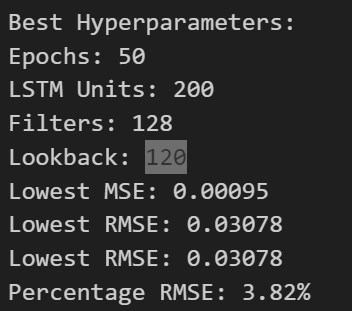

In [ ]:
# Initialize variables to track the best results
best_mse = float('inf')  # Set initial best MSE to a very large number
best_rmse = float('inf')  # Set initial best RMSE to a very large number
best_params = {}

# New hyperparameters as per the request
epochs = [25, 50, 100]
lstm_units = [32, 100, 200]
filters = [32, 64, 128]
lookbacks = [7, 30, 120]

for epoch in epochs:
    for lstm_unit in lstm_units:
        for filter_size in filters:
            for lookback in lookbacks:
                print(f"Training with epoch={epoch}, lstm_units={lstm_unit}, filters={filter_size}, lookback={lookback}")

                # Data preprocessing with the current lookback value
                X, y = create_sequences(scaled_df.values, lookback=lookback)

                # Train-test split
                train_size = int(len(X) * 0.8)
                X_train, X_test = X[:train_size], X[train_size:]
                y_train, y_test = y[:train_size], y[train_size:]

                # Reshape for LSTM input
                X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
                X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

                # Build the model with current hyperparameters
                model = Sequential()
                model.add(Conv1D(filters=filter_size, kernel_size=3, strides=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
                model.add(Dropout(0.35))  # Updated dropout to 0.35
                model.add(LSTM(units=lstm_unit, return_sequences=False, activation='tanh'))
                model.add(Dense(units=2))  # Output for Close and Open prices
                model.compile(optimizer=Adam(), loss='mean_squared_error')

                # Train the model
                history = model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_data=(X_test, y_test), verbose=0)

                # Get final validation loss
                val_loss = history.history['val_loss'][-1]

                # Calculate MSE and RMSE
                y_pred = model.predict(X_test)
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)

                # Print the results for this iteration
                print(f"Training Loss: {history.history['loss'][-1]:.5f}")
                print(f"Validation Loss: {val_loss:.5f}")
                print(f"MSE: {mse:.5f}, RMSE: {rmse:.5f}")
                print('-' * 50)

                # Track the best result
                if mse < best_mse:
                    best_mse = mse
                    best_rmse = rmse
                    best_params = {
                        'epoch': epoch,
                        'lstm_units': lstm_unit,
                        'filters': filter_size,
                        'lookback': lookback
                    }

# Print the best combination with the lowest MSE and RMSE
print("Best Hyperparameters:")
print(f"Epochs: {best_params['epoch']}")
print(f"LSTM Units: {best_params['lstm_units']}")
print(f"Filters: {best_params['filters']}")
print(f"Lookback: {best_params['lookback']}")
print(f"Lowest MSE: {best_mse:.5f}")
print(f"Lowest RMSE: {best_rmse:.5f}")

# Calculate Mean Actual Price of Close and Open Prices
mean_actual_price = np.mean(y_test)

# Compute Percentage RMSE
percentage_rmse = (best_rmse / mean_actual_price) * 100

# Display the result
print(f"Lowest RMSE: {best_rmse:.5f}")
print(f"Percentage RMSE: {percentage_rmse:.2f}%")